In [1]:
import numpy as np
from numpy import linalg

import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate

In [2]:
# Run cell to increase font sizes. Usefull when saving plots
SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (12,9)

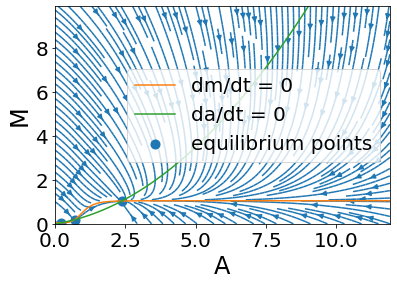

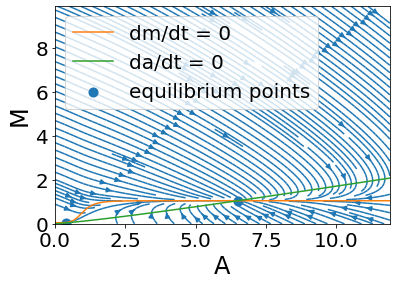

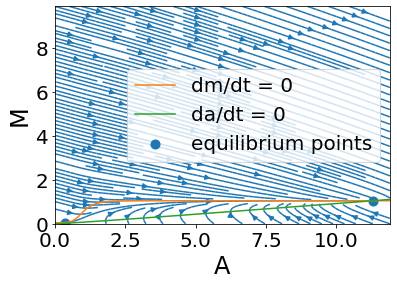

In [3]:
def dMdt(M, A, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):
    return k1 + k2 * (1 - (1/(1 + A**n))) - k3 * M

def dAdt(M, A, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):
    return k4 * M * L - k5 * A - Vmax* M * A / (Km + A)

def M_nullcline(M, A, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):
    return (k1 + k2 * (1 - 1/(1 + A**n))) / k3

def A_nullcline(M, A, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):
    return k5 * A / (k4 * L - (Vmax * A) / (Km + A))

def root_func(x, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):

     A, M = x
     return [dAdt(M, A, L, Vmax=Vmax, n=n, Km=Km, k1=k1, k2=k2, k3=k3, k4=k4, k5=k5),
               dMdt(M, A, L, Vmax=Vmax, n=n, Km=Km, k1=k1, k2=k2, k3=k3, k4=k4, k5=k5)]

def obtain_equilibrium_points(L, M_guesses, A_guesses, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):

     n_digits = 3
     M_min, M_max = M_guesses[0], M_guesses[-1]
     A_min, A_max = A_guesses[0], A_guesses[-1]

     solutions = set()
     for M in M_guesses:
          for A in A_guesses:

               sol = optimize.root(root_func, [A, M], args=(L, ), method='lm')
               
               sol_A = sol.x[0]
               sol_M = sol.x[1]

               if M_min < sol_M < M_max and A_min < sol_A < A_max:
                    sol = (round(sol_A, n_digits), round(sol_M, n_digits))
                    solutions.add(tuple(sol))

     return np.array(list(solutions))

def plot_lac_operon_streamplot(Ms, As, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):
    
    # Compute the change of M and A for all values in the lists Ms and As
    x_velocities, y_velocities = [], []
    for M in Ms:

        x_temp, y_temp = [], []
        
        for A in As:
            x_temp.append(dAdt(M, A, L))
            y_temp.append(dMdt(M, A, L))

        x_velocities.append(x_temp)
        y_velocities.append(y_temp)

    # Compute nullclines for dm/dt=0 and da/dt=0
    m_nulls = M_nullcline(Ms, As, L)
    a_nulls = A_nullcline(Ms, As, L)

    # Compute equilibrium points
    equilibrium_points = obtain_equilibrium_points(L, Ms, As, Vmax=Vmax, n=n, Km=Km, k1=k1, k2=k2, k3=k3, k4=k4, k5=k5)


    x_velocities = np.array(x_velocities)
    y_velocities = np.array(y_velocities)

    plt.ylim(Ms[0], Ms[-1])
    plt.streamplot(As, Ms, x_velocities, y_velocities, density=2)

    plt.plot(As, m_nulls, label="dm/dt = 0")
    plt.plot(As, a_nulls, label="da/dt = 0")
    
    plt.scatter(equilibrium_points[:,0], equilibrium_points[:, 1], marker="o", alpha=1, s=50, linewidths=3, label="equilibrium points")

    plt.xlabel("A")
    plt.ylabel("M")

    plt.legend()
    plt.show()

%matplotlib inline

As = np.arange(0, 12, 0.1)
Ms = np.arange(0, 10, 0.1)
plot_lac_operon_streamplot(Ms, As, L=1)
plot_lac_operon_streamplot(Ms, As, L=2)
plot_lac_operon_streamplot(Ms, As, L=3)



In [4]:
def jacobian(x, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):

     A, M = x
     J = [[-k5  - Vmax * M * Km / (Km + A) ** 2, 
            k4 * L - Vmax * A / (Km + A)],
          [n * k2 * A ** (n - 1) / (1 + A ** n) ** 2, 
           -k3]]

     return np.array(J)

def identify_equilibrium_points(equilibrium_points, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):

     for equilibrium_point in equilibrium_points:

          jacob = jacobian(equilibrium_point, L, Vmax=Vmax, n=n, Km=Km, k1=k1, k2=k2, k3=k3, k4=k4, k5=k5)
          
          eigenvalues = linalg.eigvals(jacob)

          print(f"{equilibrium_point}: {eigenvalues}")
          
print("L=1")
points = obtain_equilibrium_points(1, Ms, As)
identify_equilibrium_points(points, 1)

print("L=2")
points = obtain_equilibrium_points(2, Ms, As)
identify_equilibrium_points(points, 2)

print("L=3")
points = obtain_equilibrium_points(3, Ms, As)
identify_equilibrium_points(points, 3)


L=1
[2.372 1.037]: [-0.29086813 -1.01763655]
[0.691 0.186]: [ 0.25318693 -1.50455764]
[0.227 0.051]: [-0.20557626 -1.01499021]
L=2
[6.487 1.05 ]: [-0.22904733 -1.00010752]
[0.394 0.047]: [ 5.01382808e-04 -1.21690273e+00]
L=3
[0.349 0.028]: [-6.70441607e-04 -1.20947853e+00]
[11.29  1.05]: [-0.21188307 -1.00000659]


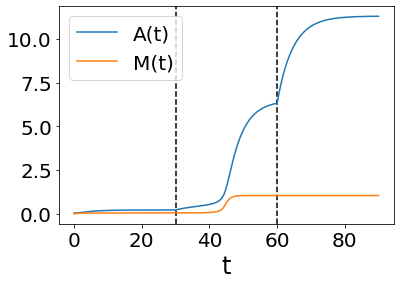

In [5]:
def lac_operon(y, t, L):

    A, M = y
    dydt = [dAdt(M, A, L), dMdt(M, A, L)]
    return dydt

def lac_operon_excercise(y):
    
    y0 = y
    t0 = np.linspace(0, 30, 301)
    sol0 = integrate.odeint(lac_operon, y0, t0, args=(1,))

    y1 = sol0[-1]
    t1 = np.linspace(30, 60, 301)
    sol1 = integrate.odeint(lac_operon, y1, t1, args=(2,))

    y2 = sol1[-1]
    t2 = np.linspace(60, 90, 301)
    sol2 = integrate.odeint(lac_operon, y2, t2, args=(3,))

    # Combine the solutions 
    t = np.concatenate((t0, t1, t2))
    sol = np.concatenate((sol0, sol1, sol2))

    ymin, ymax = np.min(sol), np.max(sol)

    plt.axvline(30, ls="--", color="k")
    plt.axvline(60, ls="--", color="k")
    plt.plot(t, sol[:, 0], label="A(t)")
    plt.plot(t, sol[:, 1], label="M(t)")
    plt.legend()
    plt.xlabel("t")
    plt.show()

%matplotlib inline
lac_operon_excercise([0.05, 0])